# Projet de DataMining :  

Dans ce projet nous allons recommander des images en fonctions d'images déjà "liké".
Pour cela nous avons commencé par traiter une base de 733 images en recupérant le maximun de données. On recupére notament les données Exif, la taille de l'image, son orientation, ect ...  
La base de données d'images vient du lien suivant:
https://www.kaggle.com/aksha05/flower-image-dataset
## Requirements : 

In [1]:
from PIL import Image
from pandas import json_normalize
import pandas as pd
import json
import os
import numpy
import math
import matplotlib.pyplot as plot
import time
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import graphviz
import pydotplus
from IPython.display import Image, display

## Récupération des données et organisation de ces données dans un fichier json:

``` python
path = "images/flowers"
dataJson = open('data.json', 'w')
dataTot = []
for file in os.listdir(path): #On peut lire l'ensemble des fichiers présents dans le dossier donné par path
    data = {}
    if file[0] != ".": #On exclue les fichiers "cachés"
        new_path = path + "/" + file
        image = Image.open(new_path) #Récupération de l'image avec le module Image de PIL
        tupleSize = image.size
        data["id_picture"] = file[-9:-4]
        data["name"] = file[:-10]
        data["size"] = tupleSize
        data["format"] = image.format
        data["couleur 1"] = ''
        data["couleur 2"] = ''
        data["couleur 3"] = ''
        data["couleur 4"] = ''
        if tupleSize[0] > tupleSize[1] : 
            data["orientation"] = "paysage"
        elif tupleSize[0] < tupleSize[1] :
            data["orientation"] = "portrait"
        else:
            data["orientation"] = "carre"
        dataTot.append(data)

json.dump(dataTot,dataJson, indent = 4)
dataJson.close()
dataTot_frame = json_normalize(dataTot)
print(dataTot_frame)

````

## Détection des couleurs prédominantes

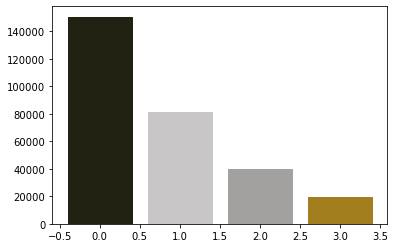

1.9640603065490723


In [2]:
start_time = time.time()
imgfile = Image.open("images/flowers/daisies_00046.jpg")
n_clusters = 4 #int(input("Nombre de clusters pour l'algorithme des K-Means: "))
numarray = numpy.array(imgfile.getdata(), numpy.uint8)
clusters = KMeans(n_clusters)
clusters.fit(numarray)
npbins = numpy.arange(0, n_clusters+1)
histogram = numpy.histogram(clusters.labels_, bins=npbins)
labels = numpy.unique(clusters.labels_)
index1 = {}
for i,element in enumerate(histogram[0]):
    index1[element] = i
#print(index1)
histoSort = sorted(histogram[0], reverse=True)
#print(histoSort)
index2 = {}
for i,element in enumerate(histoSort):
    index2[i] = element
#print(index2)
barlist = plot.bar(labels, histoSort)
colors = []
for k in range(n_clusters):
    i = index1[index2[k]]
    colors.append('#%02x%02x%02x' % (
    math.ceil(clusters.cluster_centers_[i][0]), 
        math.ceil(clusters.cluster_centers_[i][1]),
    math.ceil(clusters.cluster_centers_[i][2])))
    barlist[k].set_color('#%02x%02x%02x' % (
    math.ceil(clusters.cluster_centers_[i][0]), 
        math.ceil(clusters.cluster_centers_[i][1]),
    math.ceil(clusters.cluster_centers_[i][2])))
plot.show()
end_time = time.time()
total_time = end_time - start_time
print(total_time)

C:\tools\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


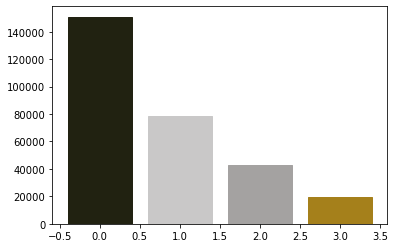

0.44320011138916016


In [3]:
start_time = time.time()
imgfile = Image.open("images/flowers/daisies_00046.jpg")
n_clusters = 4
numarray = numpy.array(imgfile.getdata(), numpy.uint8)
clusters = MiniBatchKMeans(n_clusters)
clusters.fit(numarray)
npbins = numpy.arange(0, n_clusters+1)
histogram = numpy.histogram(clusters.labels_, bins=npbins)
labels = numpy.unique(clusters.labels_)
index1 = {}
for i,element in enumerate(histogram[0]):
    index1[element] = i
#print(index1)
histoSort = sorted(histogram[0], reverse=True)
#print(histoSort)
index2 = {}
for i,element in enumerate(histoSort):
    index2[i] = element
#print(index2)
barlist = plot.bar(labels, histoSort)
colors = []
colorsDec = []
for k in range(n_clusters):
    i = index1[index2[k]]
    colors.append('#%02x%02x%02x' % (
    math.ceil(clusters.cluster_centers_[i][0]), #RGB normalement 0:R 1:G 2:B
        math.ceil(clusters.cluster_centers_[i][1]),
    math.ceil(clusters.cluster_centers_[i][2])))
    
    colorsDec.append([math.ceil(clusters.cluster_centers_[i][0]), #RGB normalement 0:R 1:G 2:B
        math.ceil(clusters.cluster_centers_[i][1]),
    math.ceil(clusters.cluster_centers_[i][2])])
    
    barlist[k].set_color('#%02x%02x%02x' % (
    math.ceil(clusters.cluster_centers_[i][0]), 
        math.ceil(clusters.cluster_centers_[i][1]),
    math.ceil(clusters.cluster_centers_[i][2])))

plot.show()
end_time = time.time()
total_time = end_time - start_time
print(total_time)

On recupere un base de données comprenant un certain nombre de couleurs permetant d'avoir des réferences

In [4]:
jsondataColor = json.load(open("colours_rgb_shades.json"))
array = []

for data in jsondataColor:
    array.append([data["Color Name"], data["Credits"], data["R;G;B Dec"]])
    
dataframe = pd.DataFrame(array, columns=["Color Name", "Credits", "R;G;B Dec"])
dataframe = dataframe.astype(
    dtype={"Color Name": "<U200", "Credits": "<U200", "R;G;B Dec": "<U200"}
)
selectColor = dataframe.loc[(dataframe["Credits"] == "N,V,X")  | (dataframe["Credits"] == "N,X")]
print(selectColor)



selectColor.to_json (r'dataSelectColor.json',orient = "index",indent = 4)



    Color Name Credits    R;G;B Dec
10       black   N,V,X        0;0;0
215       blue   N,V,X      0;0;255
222       cyan     N,X    0;255;255
342      green     N,X      0;255;0
471        red   N,V,X      255;0;0
514    magenta     N,X    255;0;255
595      white   N,V,X  255;255;255
633     yellow   N,V,X    255;255;0


Ici on remarque bien que l'algorithme MiniBatchKMeans va beaucoup plus vite que l'algorithme des KMeans bien qu'il soit moins précis. Nous décidons de l'utiliser tout de même car nous ne pouvons pas nous permettre de prendre trop de temps pour traiter les 700 images !

Nous obtenons des coulours et maintenant nous essayons d'approximer les couleurs

In [5]:
with open('dataSelectColor.json') as mon_fichier:
    data = json.load(mon_fichier)
colorList = [] 
for key in data :
    colorList.append([data[key]['Color Name'],data[key]['R;G;B Dec'].split(";")])
#modilfication type RGB 
for element in colorList :
    element[1][0] = int(element[1][0])
    element[1][1] = int(element[1][1])
    element[1][2] = int(element[1][2])

ListeCouleurs = colorList

On utilise les couleurs de réference dans notre detection de couleurs

In [6]:
print(colorsDec)

data = {}
for i in range(0,4) : 
    R = colorsDec[i][0]
    G = colorsDec[i][1]
    B = colorsDec[i][2]


    #ListeCouleurs = [[255,255,255],[0,0,255],[0,0,125],[0,255,0],[255,0,0],[0,0,0]]
    normeMin = 255
    couleursRef = []
    for couleurs in ListeCouleurs :
        norme = (abs(couleurs[1][0]-R) + abs(couleurs[1][1]-G) + abs(couleurs[1][2]-B))/3
        if norme <= normeMin : 
            couleursRef = couleurs
            normeMin = norme
    data["couleur " + str(i)] = couleursRef
print(data)


[[33, 34, 17], [201, 200, 200], [164, 162, 161], [165, 128, 27]]
{'couleur 0': ['black', [0, 0, 0]], 'couleur 1': ['white', [255, 255, 255]], 'couleur 2': ['white', [255, 255, 255]], 'couleur 3': ['yellow', [255, 255, 0]]}


On modifie le fichier JSON pour les couleurs 

```python  
filename = 'data.json'
with open(filename, 'r') as f:
    data = json.load(f)
    data[0]['couleur 1'] = 12

os.remove(filename)
with open(filename, 'w') as f:
    json.dump(data, f, indent=4)

```

On passe maintenant à l'application de l'exemple au projet

```python  
filename = 'data.json'
with open(filename, 'r') as f:
    data = json.load(f)

print(len(data))
for index in range (len(data )):
    path = "images/flowers/" + data[index]['name'] + "_" + data[index]['id_picture'] + ".jpg"
    
    print(path)
    #MiniBatchKmeans

    imgfile = Image.open(path)
    n_clusters = 4
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    clusters = MiniBatchKMeans(n_clusters)
    clusters.fit(numarray)
    npbins = numpy.arange(0, n_clusters+1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)
    index1 = {}
    for i,element in enumerate(histogram[0]):
        index1[element] = i
    #print(index1)
    histoSort = sorted(histogram[0], reverse=True)
    #print(histoSort)
    index2 = {}
    for i,element in enumerate(histoSort):
        index2[i] = element
    #print(index2)
    barlist = plot.bar(labels, histoSort)
    colors = []
    colorsDec = []
    for k in range(n_clusters):
        i = index1[index2[k]]
        colors.append('#%02x%02x%02x' % (
        math.ceil(clusters.cluster_centers_[i][0]), #RGB normalement 0:R 1:G 2:B
            math.ceil(clusters.cluster_centers_[i][1]),
        math.ceil(clusters.cluster_centers_[i][2])))

        colorsDec.append([math.ceil(clusters.cluster_centers_[i][0]), #RGB normalement 0:R 1:G 2:B
            math.ceil(clusters.cluster_centers_[i][1]),
        math.ceil(clusters.cluster_centers_[i][2])])

        barlist[k].set_color('#%02x%02x%02x' % (
        math.ceil(clusters.cluster_centers_[i][0]), 
            math.ceil(clusters.cluster_centers_[i][1]),
        math.ceil(clusters.cluster_centers_[i][2])))
        
#comparaison des couleurs :        

    dataCouleurs = {}
    for i in range(0,4) : 
        R = colorsDec[i][0]
        G = colorsDec[i][1]
        B = colorsDec[i][2]


        #ListeCouleurs = [[255,255,255],[0,0,255],[0,0,125],[0,255,0],[255,0,0],[0,0,0]]
        normeMin = 255
        couleursRef = []
        for couleurs in ListeCouleurs :
            norme = (abs(couleurs[1][0]-R) + abs(couleurs[1][1]-G) + abs(couleurs[1][2]-B))/3
            if norme <= normeMin : 
                couleursRef = couleurs
                normeMin = norme
        data[index]['couleur ' +  str(i)] = couleursRef


os.remove(filename)
with open(filename, 'w') as f:
    json.dump(data, f, indent=4)
    
        



```


Le but est maintenant de créer l'algorithme de visualisation des données permettant de voir le nombre d'image par couleur, et le nombre d'image paysage, carré et portrait

paysage     504
portrait    145
carre        84
Name: orientation, dtype: int64


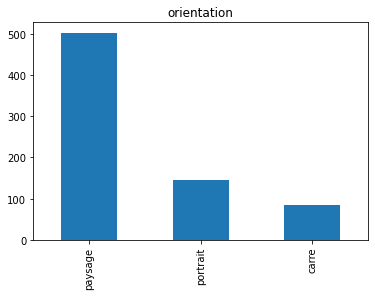

In [7]:
filename = 'data.json'
arrayVisu = []
with open(filename, 'r') as f:
    dataVisu = json.load(f)
    
for data in dataVisu:
    arrayVisu.append([data["name"],data["couleur 0"], data["couleur 1"], 
                  data["couleur 2"], data["couleur 3"], data["orientation"]])

dataframeVisu = pd.DataFrame(arrayVisu, columns=["name", "couleur 0","couleur 1","couleur 2","couleur 3", "orientation"])
dataframeVisu = dataframeVisu.astype(
    dtype={"name": "<U200", "couleur 0": "<U200", "couleur 1": "<U200","couleur 2": "<U200",
           "couleur 3": "<U200","orientation": "<U200"}
)
countName = dataframeVisu['name'].value_counts()
countOrientation = dataframeVisu['orientation'].value_counts()
couleur0 = dataframeVisu['couleur 0'].value_counts()
couleur1 = dataframeVisu['couleur 1'].value_counts()
couleur2 = dataframeVisu['couleur 2'].value_counts()
couleur3 = dataframeVisu['couleur 3'].value_counts()
axes = countOrientation.plot.bar(rot=90, subplots=True)

print(countOrientation)


daisies          83
lilies           81
gardenias        77
peonies          75
bougainvillea    74
garden_roses     74
hibiscus         74
tulip            71
orchids          64
hydrangeas       60
Name: name, dtype: int64


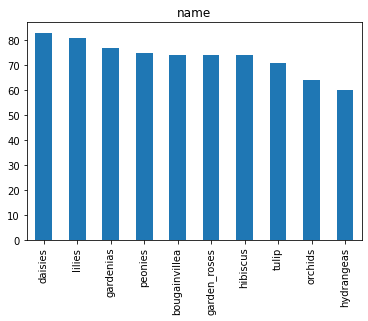

In [8]:
vx = countName.plot.bar(rot=90,subplots=True)
print(countName)

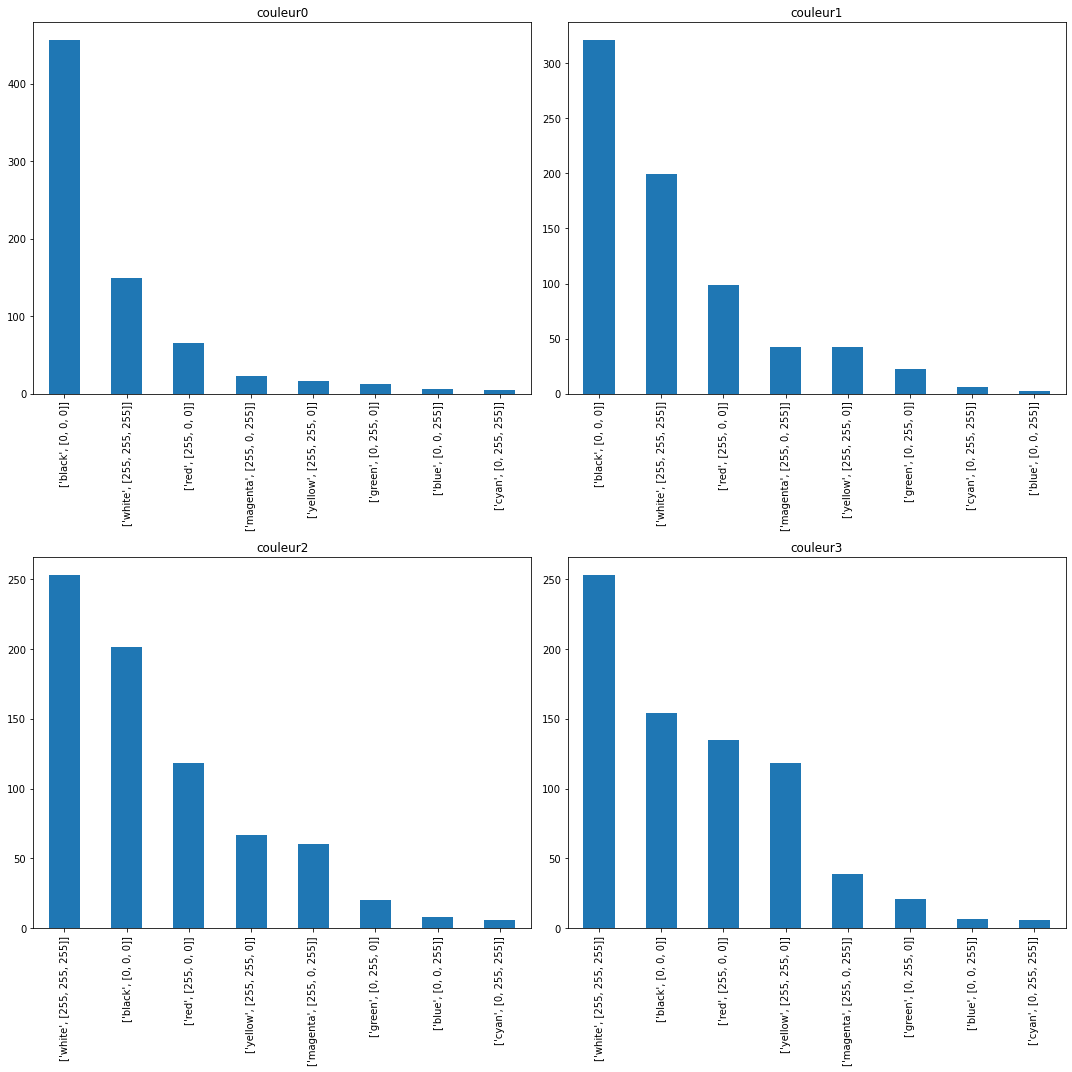

In [18]:
fig, axes = plot.subplots(nrows=2, ncols=2, figsize=(15,15))
#Creation des subplots

couleur0.plot(kind='bar',title="couleur0", ax=axes[0,0])
couleur1.plot(kind='bar',title="couleur1", ax=axes[0,1])
couleur2.plot(kind='bar',title="couleur2", ax=axes[1,0])
couleur3.plot(kind='bar',title="couleur3", ax=axes[1,1])
plot.show()

## Gestion des likes sur les photos

In [ ]:
filename = 'data.json'
dataTot = []
dataPredict = []
with open(filename, 'r') as f:
    dataJson = json.load(f)
    
for i,data in enumerate(dataJson):
        dataTot.append([data["name"],data["couleur 0"][0], data["couleur 1"][0], 
                  data["couleur 2"][0], data["couleur 3"][0], data["orientation"]])
# On s'assûre que tous les types de fleur, et couleurs et orientation sont passés aux classificateurs
# Pour qu'il ne plante pas
dataTraining = [['bougainvillea','magenta','magenta','magenta','magenta','portrait'],
                ['daisies','black','black','black','black','carre'],
                ['lilies','white','white','white','white','paysage'],
                ['gardenias','red','red','red','red','paysage'],
                ['peonies','yellow','yellow','yellow','yellow','paysage'],
                ['garden_roses','green','green','green','green','paysage'],
                ['hibiscus','blue','blue','blue','blue','paysage'],
                ['tulip','cyan','cyan','cyan','cyan','paysage'],
                ['orchids','white','white','white','white','paysage'],
                ['hydrangeas','black','black','black','black','paysage']]

for i in range(len(dataTot)):
    if i%2 == 0:
        dataTraining.append(dataTot[i])
    else:
        dataPredict.append(dataTot[i])

result = ['Favorite','Favorite','Favorite','Favorite','Favorite','Favorite','Favorite','Favorite','Favorite','Favorite']    
for i in range(len(dataTraining)):
    if i <= 46: #On veut aimer seulement les bougainvillea
        if i >= 10:
            result.append('Favorite')
    else:
        result.append('NotFavorite')

print(dataTraining)
print(result)

#creating dataframes
dataframe = pd.DataFrame(dataTraining, columns=['name', 'couleur 0', 'couleur 1', 'couleur 2', 'couleur 3', 'orientation'])
resultframe = pd.DataFrame(result, columns=['favorite'])
predictframe = pd.DataFrame(dataPredict, columns=['name', 'couleur 0', 'couleur 1', 'couleur 2', 'couleur 3', 'orientation'])
#generating numerical labels
le1 = LabelEncoder()
dataframe['name'] = le1.fit_transform(dataframe['name'])
predictframe['name'] = le1.fit_transform(predictframe['name'])

le2 = LabelEncoder()
dataframe['couleur 0'] = le2.fit_transform(dataframe['couleur 0'])
predictframe['couleur 0'] = le2.fit_transform(predictframe['couleur 0'])

le3 = LabelEncoder()
dataframe['couleur 1'] = le3.fit_transform(dataframe['couleur 1'])
predictframe['couleur 1'] = le3.fit_transform(predictframe['couleur 1'])

le4 = LabelEncoder()
dataframe['couleur 2'] = le4.fit_transform(dataframe['couleur 2'])
predictframe['couleur 2'] = le4.fit_transform(predictframe['couleur 2'])

le5 = LabelEncoder()
dataframe['couleur 3'] = le5.fit_transform(dataframe['couleur 3'])
predictframe['couleur 3'] = le5.fit_transform(predictframe['couleur 3'])

le6 = LabelEncoder()
dataframe['orientation'] = le6.fit_transform(dataframe['orientation'])
predictframe['orientation'] = le6.fit_transform(predictframe['orientation'])

le7 = LabelEncoder()
resultframe['favorite'] = le7.fit_transform(resultframe['favorite'])

#Use of decision tree classifiers
rfc = RandomForestClassifier(n_estimators=10, max_depth=6,
                  random_state=0,)
rfc = rfc.fit(dataframe, resultframe.values.ravel())

for i in range(10):
        dot_data = tree.export_graphviz(rfc.estimators_[i], out_file=None,
        feature_names=dataframe.columns,
        filled=True, rounded=True,
        class_names =
         le7.inverse_transform(
           resultframe.favorite.unique())
        ) 
        graph = graphviz.Source(dot_data) 
        pydot_graph = pydotplus.graph_from_dot_data(dot_data)
        img = Image(pydot_graph.create_png())
        display(img)
        
prediction1 = rfc.predict([
        [le1.transform(['daisies'])[0], le2.transform(['white'])[0],
         le3.transform(['black'])[0], le4.transform(['white'])[0], le5.transform(['yellow'])[0], le6.transform(['portrait'])[0]]])
print("Daisy: " + str(le7.inverse_transform(prediction1)))
prediction2 = rfc.predict([
        [le1.transform(['bougainvillea'])[0], le2.transform(['white'])[0],
         le3.transform(['black'])[0], le4.transform(['white'])[0], le5.transform(['yellow'])[0], le6.transform(['portrait'])[0]]])
print("Bougainvillea: " + str(le7.inverse_transform(prediction2)))
prediction3 = rfc.predict(predictframe)
print(le7.inverse_transform(prediction3))
print(rfc.feature_importances_)


Ici nous utilisons des randoms forest que nous entraînons à partir de la moitié de nos photos (nous avons pris une photo sur deux dans le fichier). Et nous faisons des prédictions sur la moitié restante.